In [1083]:
%pip install seglearn

     |████████████████████████████████| 11.3 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 85.7 MB/s eta 0:00:01
     |████████████████████████████████| 22.3 MB 25.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 60.5 MB/s 
     |████████████████████████████████| 27.4 MB 63.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [1084]:
import argparse
import datetime
import bisect
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

from seglearn.pipe import Pype
from seglearn.split import temporal_split, TemporalKFold
from seglearn.transform import FeatureRep, Segment, last

In [1085]:
class HardwareLogItem:
    def __init__(self,
                 date,
                 time,
                 cpu_usage_value,
                 mem_usage_in_gb,
                 gpu_avg_mem_usage,
                 gpu_max_mem_usage,
                 gpu_temp,
                 gpu_power_consumption,
                 gpu_utilization):
        self.timestamp = datetime.datetime.strptime(" ".join([date, time]), '%Y-%m-%d %H:%M:%S.%f')
        self.cpu_usage_value = cpu_usage_value
        self.mem_usage_in_gb = mem_usage_in_gb
        self.gpu_avg_mem_usage = gpu_avg_mem_usage
        self.gpu_max_mem_usage = gpu_max_mem_usage
        self.gpu_temp = gpu_temp
        self.gpu_power_consumption = gpu_power_consumption
        self.gpu_utilization = gpu_utilization

    def key(self):
        return self.timestamp

    def value(self):
        return [self.cpu_usage_value,
                self.mem_usage_in_gb,
                self.gpu_avg_mem_usage,
                self.gpu_max_mem_usage,
                self.gpu_temp,
                self.gpu_power_consumption,
                self.gpu_utilization]

    def to_features_dict(self):
        return {"cpu_usage_value": self.cpu_usage_value,
                "mem_usage_in_gb": self.mem_usage_in_gb,
                "gpu_avg_mem_usage": self.gpu_avg_mem_usage,
                "gpu_max_mem_usage": self.gpu_max_mem_usage,
                "gpu_temp": self.gpu_temp,
                "gpu_power_consumption": self.gpu_power_consumption,
                "gpu_utilization": self.gpu_utilization
                }

In [1086]:
class NetworkLogItem:
    def __init__(self,
                 timestamp,
                 connections_count,
                 opened_files,
                 read_ops,
                 write_ops,
                 read_bytes,
                 write_bytes):
            
        self.timestamp = timestamp
        self.connections_count = connections_count
        self.opened_files = opened_files
        self.read_ops = read_ops
        self.write_ops = write_ops
        self.read_bytes = read_bytes
        self.write_bytes = write_bytes

    def key(self):
        return self.timestamp

    def value(self):
        return [self.connections_count,
                self.opened_files,
                self.read_ops,
                self.write_ops,
                self.read_bytes,
                self.write_bytes]

    def to_features_dict(self):
        return {"connections_count": self.connections_count,
                "opened_files": self.opened_files,
                "read_ops": self.read_ops,
                "write_ops": self.write_ops,
                "read_bytes": self.read_bytes,
                "write_bytes": self.write_bytes
                }

In [1087]:
class PreRequestInfo:
    def __init__(self, normalize_partials, sample_rate, channels_count):
        self.normalize_partials = normalize_partials
        self.sample_rate = sample_rate
        self.channels_count = channels_count

In [1088]:
class SessionItem:
    def __init__(self,
                 start_timestamp,
                 normalize_partials,
                 sample_rate,
                 channels_count,
                 received_time,
                 session_time):
        self.start_timestamp = start_timestamp
        self.normalize_partials = normalize_partials
        self.sample_rate = sample_rate
        self.channels_count = channels_count
        self.received_time = received_time
        self.session_time = session_time

    def to_features_dict(self):
        return {"normalize_partials": self.normalize_partials,
                "sample_rate": self.sample_rate,
                "channels_count": self.channels_count,
                #"received_time": self.received_time
                }

    def get_received_time(self):
        return self.received_time

    def get_session_time(self):
        return self.session_time

    def label(self):
        #if self.received_time == 0:
        #    print(self.to_features_dict(), self.get_session_time())
        #return self.received_time / (self.session_time * 1000.0) < 0.5

        return self.session_time * 1000.0

In [1089]:
def parse_hardware_log(log_path):
    result_items = []
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            items = log_line.split()
            log_level, date, time, zone, file_ = items[0], items[1], items[2], items[3], items[4]
            cpu_usage_value, mem_usage_in_gb = float(items[5]), float(items[6])
            gpu_avg_mem_usage, gpu_max_mem_usage = float(items[7]), float(items[8])
            gpu_temp, gpu_power_consumption, gpu_utilization = float(items[9]), float(items[10]), float(items[11])

            result_items.append(HardwareLogItem(date,
                                                time,
                                                cpu_usage_value,
                                                mem_usage_in_gb,
                                                gpu_avg_mem_usage,
                                                gpu_max_mem_usage,
                                                gpu_temp,
                                                gpu_power_consumption,
                                                gpu_utilization))

    return result_items

In [1090]:
def parse_server_log(log_path):
    session_id_to_features = defaultdict(dict)
    chunks_ts = []
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            session_id = None
            #  starting session log line
            if "Starting session" in log_line:
                info_parts = log_line.split("#")[-1].split()
                session_id = info_parts[0]
                session_id_to_features[session_id]["start_timestamp"] = info_parts[-1]
            #  session info + req params
            elif "server.cpp:93" in log_line:
                info_parts = log_line.split()
                session_id = info_parts[-4]
                normalize_partials = int(info_parts[-3])
                sample_rate = int(info_parts[-2])
                channels_count = int(info_parts[-1])
                pre_request_info = PreRequestInfo(normalize_partials, sample_rate, channels_count)
                session_id_to_features[session_id]["pre_request_info"] = pre_request_info
            #  starting session log line
            elif "finish recognition" in log_line:
                info_parts = log_line.split()
                session_id = info_parts[-6]
                received_time = float(info_parts[-1].split("=")[-1])
                session_id_to_features[session_id]["time_info"] = received_time
            #  finish session log line
            elif "Session" in log_line and "was finished at" in log_line:
                info_parts = log_line.split("#")[-1].split()
                session_id = info_parts[0]
                session_id_to_features[session_id]["finish_timestamp"] = info_parts[-1]
            elif log_line.split()[-1] == "nc":
                parts = log_line.split()
                ts = " ".join(parts[1:3])
                ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
                chunks_ts.append(ts)
            # if session_id is not None:
            #    print(session_id_to_features[session_id])

    return session_id_to_features, chunks_ts

In [1091]:
def sessions_info_to_vec(completed_session_id_to_features):
    result_items = []
    for k, v in completed_session_id_to_features.items():
        session_time = (completed_session_id_to_features[k]["finish_timestamp"] - completed_session_id_to_features[k][
            "start_timestamp"]).total_seconds()
        pre_request_info = completed_session_id_to_features[k]["pre_request_info"]
        normalize_partials = pre_request_info.normalize_partials
        sample_rate = pre_request_info.sample_rate
        channels_count = pre_request_info.channels_count
        received_time = session_id_to_features[k]["time_info"]
        result_items.append(
            SessionItem(completed_session_id_to_features[k]["start_timestamp"], normalize_partials, sample_rate,
                        channels_count, received_time, session_time))

    return result_items

In [1092]:
def load_network_log(log_path):
    timestamp_to_network_item = {}
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            # INFO 2020-12-03 07:34:24.187 19 271 0 16 0 90112
            parts = log_line.split()
            count = int(parts[-6])
            opened_files = int(parts[-5])
            read_ops = int(parts[-4])
            write_ops = int(parts[-3])
            read_bytes = int(parts[-2])
            write_bytes = int(parts[-1])
            parts = parts[:-6]
            parts = parts[1:]
            ts = " ".join(parts)
            ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            timestamp_to_network_item[ts] = NetworkLogItem(ts, count, opened_files, read_ops, write_ops, read_bytes, write_bytes)
    
    
    print(list(timestamp_to_network_item.values())[:3])
    return timestamp_to_network_item

In [1093]:
def load_data(df):
    return df.to_numpy()[:, :-1], df.to_numpy()[:, -1], df.keys()

In [1094]:
def plot_hardware(hardware_log):
    for key in hardware_log[0].to_features_dict().keys():
        plt.clf()
        X = list(range(len(hardware_log)))
        plt.plot(X, list(map(lambda t: t.to_features_dict()[key], hardware_log)))
        plt.title(f'{key} distribution')
        plt.savefig(f'{key}_distribution.png')

In [ ]:
def train_simple(df):
    Xs, ys, keys = load_data(df)

    X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    scores = {'accuracy': accuracy_score(y_test, y_hat),
              'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1096]:
def train_time_split(df):
    Xs, ys, keys = load_data(df)
    train_size= int(0.8 * len(Xs))
    X_train, X_test, y_train, y_test = Xs[:train_size], Xs[train_size:], ys[:train_size], ys[train_size:]
    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print(y_train, y_hat)
    metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    scores = {'accuracy': accuracy_score(y_test, y_hat),
              'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1097]:
def train_time_series(df, intervals=20, classifiers_count=10):
    Xs, ys, keys = load_data(df)

    N = len(Xs)
    interval_size = int(N / intervals)
    print(f'Interval size: {interval_size}')

    models = []
    accs = []
    for it in range(intervals):
        if it < classifiers_count:
            Xs_it, ys_it = Xs[it * interval_size: (it + 1) * interval_size], ys[it * interval_size: (it + 1) * interval_size]
            train_size = int(0.8 * len(Xs_it))
            print(f'Initial step set size: {len(Xs_it)}, train_size = {train_size}')
            X_train, X_test, y_train, y_test = Xs_it[:train_size], Xs_it[train_size:], ys_it[:train_size], ys_it[train_size:]
            model = RandomForestClassifier(random_state=42 * (it + 1))
            model.fit(X_train, y_train)
            models.append(model)
        else:
            Xs_it, ys_it = Xs[it * interval_size: (it + 1) * interval_size], ys[it * interval_size: (it + 1) * interval_size]
            train_size = int(0.8 * len(Xs_it))
            print(f'Step set size: {len(Xs_it)}, train_size = {train_size}')
            X_train, X_test, y_train, y_test = Xs_it[:train_size], Xs_it[train_size:], ys_it[:train_size], ys_it[train_size:]
            model = RandomForestClassifier(random_state=42 * (it + 1))
            model.fit(X_train, y_train)
            models.append(model)

            worst_i, worst_acc = -1, 0
            for i, m in enumerate(models):
                y_hat = m.predict(X_test)
                accuracy = accuracy_score(y_test, y_hat)
                if worst_i == -1 or worst_acc > accuracy:
                    worst_i = i
                    worst_acc = accuracy

            del models[worst_i]

            predictions = []
            for i, m in enumerate(models):
                predictions.append(m.predict(X_test))

            #print(predictions)
            predictions = np.array(predictions)
            #print(predictions)
            predictions = np.sum(predictions, axis=0)
            #print(predictions)
            y_hat_all = (predictions >= int(classifiers_count / 2)).astype(int)
            accuracy = accuracy_score(y_test, y_hat_all)
            print(f'Accuracy at step: {accuracy}')
            accs.append(accuracy)


    plt.clf()
    X = list(range(len(accs)))
    plt.plot(X, accs)
    plt.savefig(f'accuracy_distribution_time_series_segs_{intervals}_classifiers_{classifiers_count}.png')



In [1098]:
def train_seglearn(df):
    X, y, keys = load_data(df)
    X = [X]
    y = [y]
    X_train, X_test, y_train, y_test = temporal_split(X, y)

    pipe = Pype([('seg', Segment(width=200, overlap=0.5, y_func=last)),
                 ('features', FeatureRep()),
                 ('lin', RandomForestClassifier())])

    # fit and score
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

    print("N series in train: ", len(X_train))
    print("N series in test: ", len(X_test))
    print("N segments in train: ", pipe.N_train)
    print("N segments in test: ", pipe.N_test)
    print("Score: ", score)


def train_time_series_all(df):
    train_time_series(df)
    train_time_series(df, intervals=50)
    train_time_series(df, intervals=50, classifiers_count=5)
    train_time_series(df, intervals=100, classifiers_count=5)
    train_time_series(df, intervals=100, classifiers_count=10)
    train_time_series(df, intervals=100, classifiers_count=2)
    train_time_series(df, intervals=100, classifiers_count=40)

In [1160]:
server_log_path = "old_notebooks/server.log"
network_log_path = "old_notebooks/disk.log"
hardware_log_path = "old_notebooks/hardware.log"
stress_test_log_path = "old_notebooks/stress_8_dec_log9.txt"

In [1161]:
hardware_log_list = parse_hardware_log(hardware_log_path)

print(f'hardware log items: {len(hardware_log_list)}')


hardware_log_list = list(sorted(hardware_log_list, key=lambda it: it.key()))
hardware_log_list_dates = list(map(lambda it: it.key(), hardware_log_list))

hardware log items: 6413


In [1162]:
session_id_to_features, chunks_ts = parse_server_log(server_log_path)
print(f'All sessions presented: {len(session_id_to_features)}')

completed_session_id_to_features = defaultdict(dict)
for k, v in session_id_to_features.items():
    #print(len(v.keys()))
    if len(v.keys()) == 4:
        #print(v.keys())
        completed_session_id_to_features[k] = v

All sessions presented: 6527


In [1163]:
    for k, v in completed_session_id_to_features.items():
        completed_session_id_to_features[k]["start_timestamp"] = datetime.datetime.strptime(v["start_timestamp"],
                                                                                            '%Y-%m-%dT%H:%M:%S.%fZ')
        completed_session_id_to_features[k]["finish_timestamp"] = datetime.datetime.strptime(v["finish_timestamp"],
                                                                                             '%Y-%m-%dT%H:%M:%S.%fZ')

    print(f'Completed sessions: {len(completed_session_id_to_features)}')
    sessions_log = sessions_info_to_vec(completed_session_id_to_features)
    print(f'Session log len: {len(sessions_log)}')
    hardware_log_set = set(hardware_log_list)

Completed sessions: 6507
Session log len: 6507


In [1164]:
session_hardware_pairs = []
timestamp_to_network_item = load_network_log(network_log_path)
network_dates = list(sorted(list(map(lambda it: it[0], timestamp_to_network_item.items()))))
print(len(network_dates))
for session in sessions_log:
    i = bisect.bisect_left(hardware_log_list_dates, session.start_timestamp, lo=0, hi=len(hardware_log_list_dates))
    j = bisect.bisect_left(network_dates, session.start_timestamp, lo=0, hi=len(network_dates))
    session_hardware_pairs.append((session, hardware_log_list[i], timestamp_to_network_item[network_dates[j]]))

print(session_hardware_pairs[0])
print(len(session_hardware_pairs))

[<__main__.NetworkLogItem object at 0x7f1d004a75d0>, <__main__.NetworkLogItem object at 0x7f1cb06f9110>, <__main__.NetworkLogItem object at 0x7f1bf8dc5f90>]
102900
(<__main__.SessionItem object at 0x7f1d004a7610>, <__main__.HardwareLogItem object at 0x7f1caad0ed90>, <__main__.NetworkLogItem object at 0x7f1ca9acef50>)
6507


In [1165]:
dataset_dicts = {}

labels = []
dataset = []
for s, h, conn in session_hardware_pairs:
    features_vec = {**s.to_features_dict(), **h.to_features_dict(), **conn.to_features_dict()}
    #features_vec["conn"] = conn
    features_vec["label"] = int(s.label())
    dataset.append(features_vec)
    #print(features_vec)
    labels.append(s.label())
    #break

labels = list(sorted(labels))

In [1166]:
def train_time_split_regr(df):
    Xs, ys, keys = load_data(df)
    train_size= int(0.8 * len(Xs))
    X_train, X_test, y_train, y_test = Xs[:train_size], Xs[train_size:], ys[:train_size], ys[train_size:]
    model = RandomForestRegressor(random_state=42)

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    #print(y_train, y_hat)
    #metrics = precision_recall_fscore_support(y_test, y_hat, average='binary')
    #scores = {'accuracy': accuracy_score(y_test, y_hat),
    #          'precision': metrics[0], 'recall': metrics[1], 'F-score': metrics[2], 'support': metrics[3]}
    print(scores)

In [1167]:
df = pd.DataFrame(dataset)

In [1168]:
print(df)

      normalize_partials  sample_rate  channels_count  cpu_usage_value  \
0                      0         8000               1         0.260163   
1                      0         8000               1         0.260163   
2                      0         8000               1         0.260163   
3                      0         8000               1         0.276639   
4                      0         8000               1         0.276639   
...                  ...          ...             ...              ...   
6502                   0         8000               1         0.989715   
6503                   0         8000               1         0.994387   
6504                   0         8000               1         0.993427   
6505                   0         8000               1         0.993427   
6506                   0         8000               1         0.993427   

      mem_usage_in_gb  gpu_avg_mem_usage  gpu_max_mem_usage  gpu_temp  \
0           13.438633       1.143629e+

In [1169]:
print(df.keys())

Index(['normalize_partials', 'sample_rate', 'channels_count',
       'cpu_usage_value', 'mem_usage_in_gb', 'gpu_avg_mem_usage',
       'gpu_max_mem_usage', 'gpu_temp', 'gpu_power_consumption',
       'gpu_utilization', 'connections_count', 'opened_files', 'read_ops',
       'write_ops', 'read_bytes', 'write_bytes', 'label'],
      dtype='object')


In [1170]:
print(len(df))

6507


In [1171]:
import matplotlib.pyplot as plt

In [1172]:
def plot_g(df, label, limit=None):
    plt.clf()
    x, y = list(range(len(df))), list(df[label])
    if limit is not None:
        x, y = x[:limit], y[:limit]
        
    plt.plot(x, y)
    plt.title(label)
    plt.show()

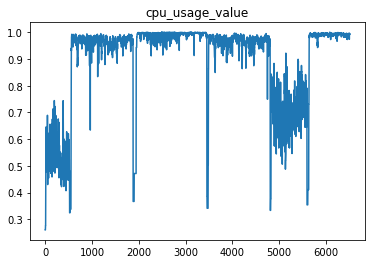

In [1173]:
plot_g(df, "cpu_usage_value")

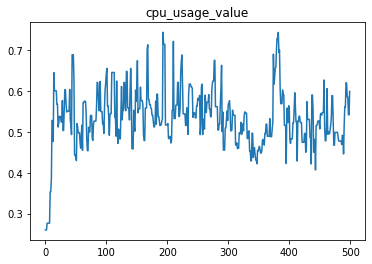

In [1174]:
plot_g(df, "cpu_usage_value", 500)

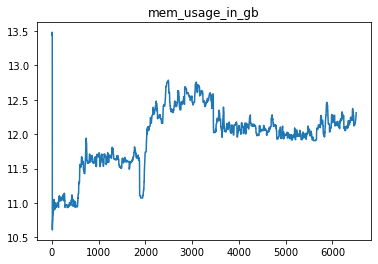

In [1175]:
plot_g(df, "mem_usage_in_gb")

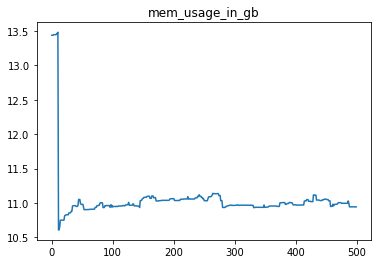

In [1176]:
plot_g(df, "mem_usage_in_gb", 500)

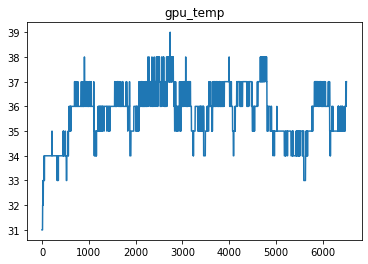

In [1177]:
plot_g(df, "gpu_temp")

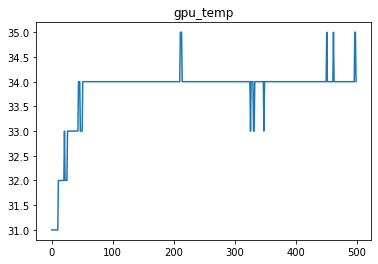

In [1178]:
plot_g(df, "gpu_temp", 500)

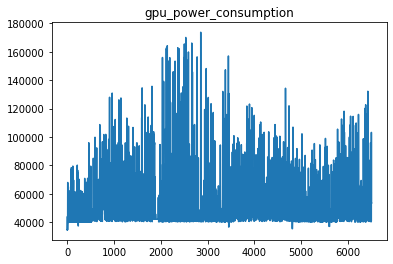

In [1179]:
plot_g(df, "gpu_power_consumption")

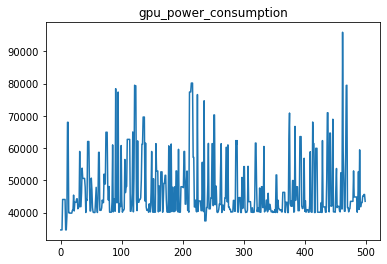

In [1180]:
plot_g(df, "gpu_power_consumption", 500)

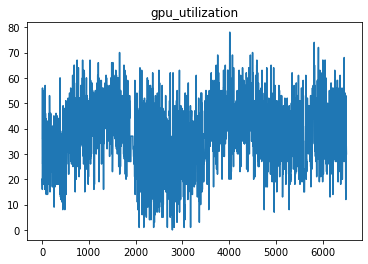

In [1181]:
plot_g(df, "gpu_utilization")

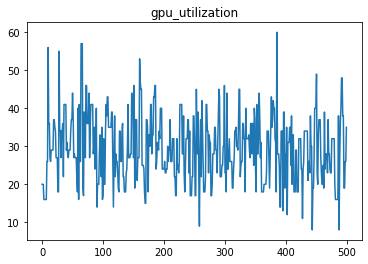

In [1182]:
plot_g(df, "gpu_utilization", 500)

In [ ]:
plot_g(df, "connections_count")

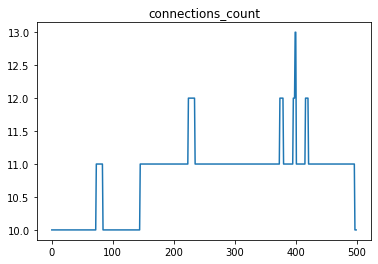

In [1184]:
plot_g(df, "connections_count", 500)

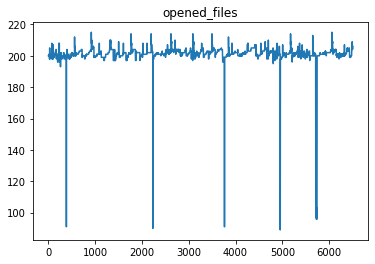

In [1185]:
plot_g(df, "opened_files")

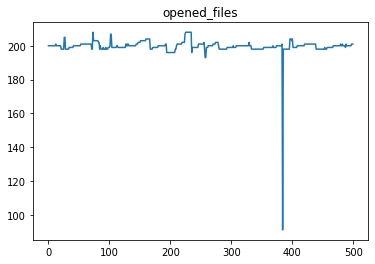

In [1186]:
plot_g(df, "opened_files", 500)

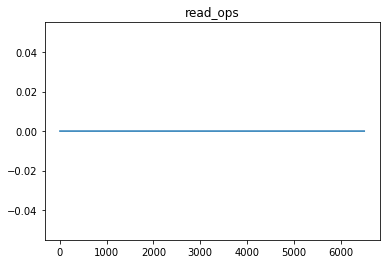

In [1187]:
plot_g(df, "read_ops")

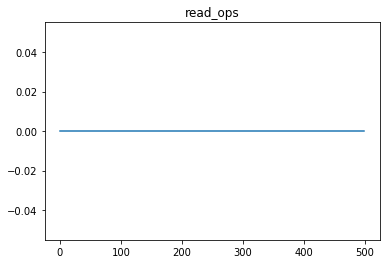

In [1188]:
plot_g(df, "read_ops", 500)

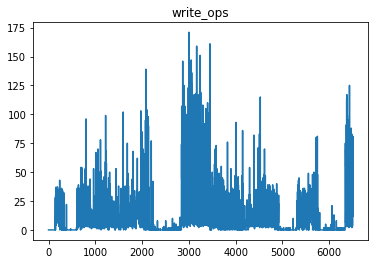

In [1189]:
plot_g(df, "write_ops")

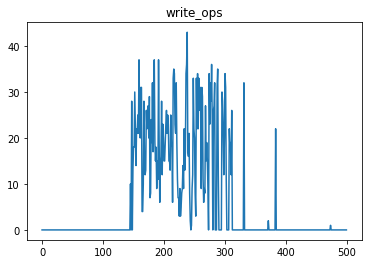

In [1190]:
plot_g(df, "write_ops", 500)

In [1191]:
from sklearn import preprocessing
x = df.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)

In [1192]:
print(df_scaled)

        0    1    2         3         4        5         6      7         8  \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.986098  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.992413  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

             9        10        11   12        13  

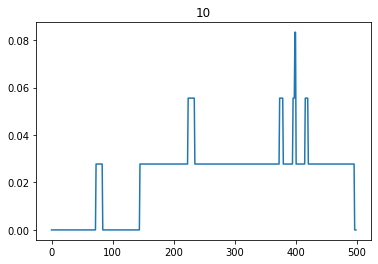

In [1133]:
plot_g(df_scaled, 10, 500)

In [1134]:
print(df_scaled)

       0    1    2         3         4        5         6      7         8   \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.992413  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

            9         10        11   12        13  

In [1135]:
train_size = int(0.8 * len(df))

In [1136]:
df_scaled[3] = df_scaled[3].shift(-1)

In [1137]:
print(df_scaled)

       0    1    2         3         4        5         6      7         8   \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.991116  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0       NaN  0.592766  1.00000  1.000000  0.750  0.135341   

            9         10        11   12        13  

In [1138]:
df_scaled[3][len(df_scaled)-1] = df_scaled[3][len(df_scaled)-2]

In [1139]:
print(df_scaled)

       0    1    2         3         4        5         6      7         8   \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.991116  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

            9         10        11   12        13  

In [1140]:
print(df_scaled)

       0    1    2         3         4        5         6      7         8   \
0     0.0  0.0  0.0  0.000000  0.984773  0.00000  0.000000  0.000  0.000000   
1     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
2     0.0  0.0  0.0  0.022270  0.984773  0.00000  0.000000  0.000  0.000000   
3     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
4     0.0  0.0  0.0  0.022270  0.987686  0.01595  0.020941  0.000  0.067918   
...   ...  ...  ...       ...       ...      ...       ...    ...       ...   
6502  0.0  0.0  0.0  0.991116  0.572189  1.00000  1.000000  0.625  0.045519   
6503  0.0  0.0  0.0  0.991116  0.580327  1.00000  1.000000  0.750  0.493315   
6504  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6505  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   
6506  0.0  0.0  0.0  0.991116  0.592766  1.00000  1.000000  0.750  0.135341   

            9         10        11   12        13  

In [1148]:
train_size = int(0.8 * len(df_scaled))
train_size

5205

In [1149]:
df_scaled_train, df_scaled_test = df_scaled[:train_size], df_scaled[train_size:]

In [1288]:
FEATURE = 3

In [1289]:
X_train, y_train = df_scaled_train.drop([FEATURE], axis=1).to_numpy(), df_scaled_train[FEATURE].to_numpy()

In [1290]:
print(X_train, y_train)

[[0.         0.         0.         ... 0.         0.         0.00059523]
 [0.         0.         0.         ... 0.         0.         0.17919281]
 [0.         0.         0.         ... 0.         0.         0.006356  ]
 ...
 [0.         0.         0.         ... 0.         0.         0.20967974]
 [0.         0.         0.         ... 0.         0.         0.00892167]
 [0.         0.         0.         ... 0.         0.         0.4023782 ]] [0.         0.02226977 0.02226977 ... 0.58718069 0.56321325 0.54731515]


In [1291]:
X_test, y_test = df_scaled_test.drop([FEATURE], axis=1).to_numpy(), df_scaled_test[FEATURE].to_numpy()

In [1292]:
print(X_test, y_test)

[[0.         0.         0.         ... 0.         0.         0.00888062]
 [0.         0.         0.         ... 0.         0.         0.01457981]
 [0.         0.         0.         ... 0.         0.         0.40268608]
 ...
 [0.         0.         0.         ... 0.         0.01236014 0.00097837]
 [0.         0.         0.         ... 0.         0.01821494 0.00513817]
 [0.         0.         0.         ... 0.         0.00312256 0.00773804]] [0.50109821 0.50109821 0.43897913 ... 0.99111561 0.99111561 0.99111561]


In [1404]:
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train, [1.0 / (len(y_train) - i) ** 0.1 for i in range (len(y_train))])
y_hat = model.predict(X_test)

In [1408]:
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
model2 = GradientBoostingRegressor(random_state=42)
model2.fit(X_train, y_train)
y_hat2 = model2.predict(X_test)

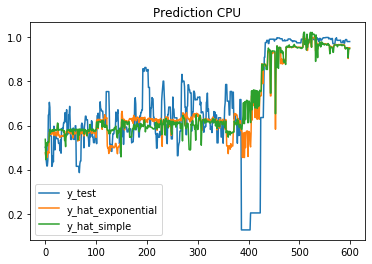

In [1409]:
plt.clf()
x, yt, yh, yh2 = list(range(len(y_test))), list(y_test), list(y_hat) , list(y_hat2)   
#x.append(len(x))
#yt.append(0)
#yh.append(0)
x = x[:600]
yt = yt[:600]
yh = yh[:600]
yh2 = yh2[:600]
plt.plot(x, yt, label="y_test")
plt.plot(x, yh, label="y_hat_exponential")
plt.plot(x, yh2, label="y_hat_simple")
plt.title("Prediction CPU")
plt.legend()
plt.show()


In [1402]:
print(model.score(X_test, y_test))

0.7203848726983533


In [1384]:
df

,normalize_partials,sample_rate,channels_count,cpu_usage_value,mem_usage_in_gb,gpu_avg_mem_usage,gpu_max_mem_usage,gpu_temp,gpu_power_consumption,gpu_utilization,connections_count,opened_files,read_ops,write_ops,read_bytes,write_bytes,label
0,0,8000,1,0.260163,13.438633,1.143629e+10,1.145150e+10,31.0,34599.0,20.0,10,200,0,0,0,0,124
1,0,8000,1,0.260163,13.438633,1.143629e+10,1.145150e+10,31.0,34599.0,20.0,10,200,0,0,0,0,26228
2,0,8000,1,0.260163,13.438633,1.143629e+10,1.145150e+10,31.0,34599.0,20.0,10,200,0,0,0,0,966
3,0,8000,1,0.276639,13.447006,1.152359e+10,1.156579e+10,31.0,44047.0,16.0,10,200,0,0,0,0,58806
4,0,8000,1,0.276639,13.447006,1.152359e+10,1.156579e+10,31.0,44047.0,16.0,10,200,0,0,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6502,0,8000,1,0.989715,12.252541,1.690934e+10,1.690934e+10,36.0,40931.0,31.0,26,205,0,23,0,176128,4011
6503,0,8000,1,0.994387,12.275936,1.690934e+10,1.690934e+10,37.0,103223.0,33.0,26,205,0,27,0,200704,2349
6504,0,8000,1,0.993427,12.311695,1.690934e+10,1.690934e+10,37.0,53426.0,30.0,26,205,0,53,0,389120,180
6505,0,8000,1,0.993427,12.311695,1.690934e+10,1.690934e+10,37.0,53426.0,30.0,26,205,0,81,0,573440,788


Index(['normalize_partials', 'sample_rate', 'channels_count',
       'mem_usage_in_gb', 'gpu_avg_mem_usage', 'gpu_max_mem_usage', 'gpu_temp',
       'gpu_power_consumption', 'gpu_utilization', 'connections_count',
       'opened_files', 'read_ops', 'write_ops', 'read_bytes', 'write_bytes',
       'label'],
      dtype='object')
Index(['connections_count', 'mem_usage_in_gb', 'gpu_temp', 'gpu_avg_mem_usage',
       'gpu_max_mem_usage'],
      dtype='object')
[0.71029197 0.12875345 0.04227728 0.03613387 0.02517529]


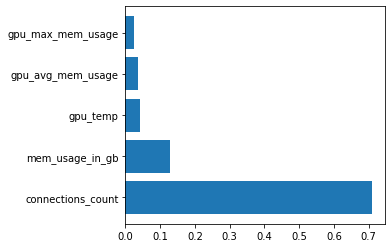

In [1418]:
importances = model.feature_importances_
ind = np.argsort(importances)[::-1]
keys = df.drop(["cpu_usage_value"], axis=1).keys()
print(keys)
print(keys[ind[:5]])
print(importances[ind[:5]])
plt.clf()
plt.gcf().subplots_adjust(left=0.3)
plt.barh(range(len(keys[ind[:5]])), importances[ind[:5]], align='center')
plt.yticks(range(len(keys[ind[:5]])), keys[ind[:5]])
plt.show()

In [1419]:
import math
samples_weight_train = []
n = len(X_train)
for i in range(len(X_train)):
    samples_weight_train.append(math.exp((4.0 / n) * i))

print(samples_weight_train[:10])

[1.0, 1.0007687872002815, 1.0015381654343223, 1.0023081351565015, 1.0030786968215477, 1.0038498508845393, 1.0046215978009037, 1.0053939380264194, 1.0061668720172146, 1.0069404002297686]


In [1420]:
from sklearn.ensemble import RandomForestRegressor
model2 = RandomForestRegressor(random_state=42)
model2.fit(X_train, y_train, sample_weight=samples_weight_train)
y_hat = model2.predict(X_test)

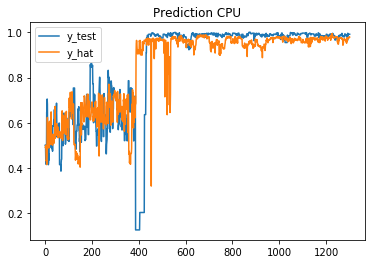

In [1421]:
plt.clf()
x, yt, yh = list(range(len(y_test))), list(y_test), list(y_hat)   
plt.plot(x, yt, label="y_test")
plt.plot(x, yh, label="y_hat")
plt.title("Prediction CPU")
plt.legend()
plt.show()

In [1422]:
print(model2.score(X_test, y_test))

0.5055081915364028


Index(['normalize_partials', 'sample_rate', 'channels_count',
       'mem_usage_in_gb', 'gpu_avg_mem_usage', 'gpu_max_mem_usage', 'gpu_temp',
       'gpu_power_consumption', 'gpu_utilization', 'connections_count',
       'opened_files', 'read_ops', 'write_ops', 'read_bytes', 'write_bytes',
       'label'],
      dtype='object')
Index(['connections_count', 'mem_usage_in_gb', 'gpu_temp', 'opened_files',
       'gpu_utilization'],
      dtype='object')
[0.69768564 0.10139756 0.06531113 0.04924769 0.02857789]


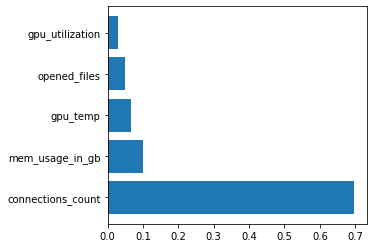

In [1423]:
importances = model2.feature_importances_
ind = np.argsort(importances)[::-1]
keys = df.drop(["cpu_usage_value"], axis=1).keys()
print(keys)
print(keys[ind[:5]])
print(importances[ind[:5]])
plt.clf()
plt.gcf().subplots_adjust(left=0.3)
plt.barh(range(len(keys[ind[:5]])), importances[ind[:5]], align='center')
plt.yticks(range(len(keys[ind[:5]])), keys[ind[:5]])
plt.show()

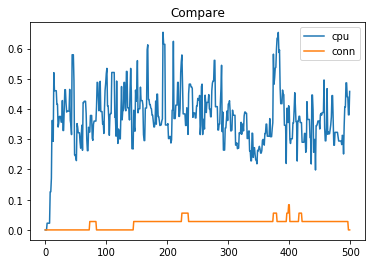

In [1424]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[10])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="conn")
plt.title("Compare")
plt.legend()
plt.show()

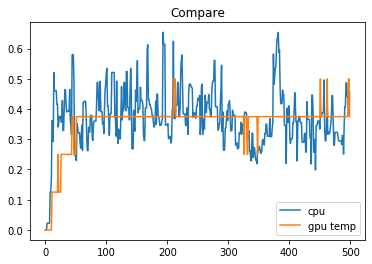

In [1425]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[7])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="gpu temp")
plt.title("Compare")
plt.legend()
plt.show()

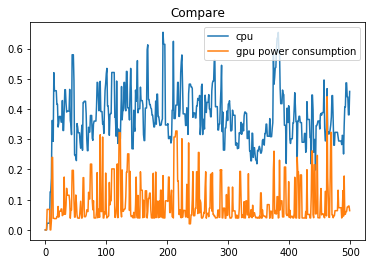

In [1426]:
plt.clf()
x, yt, yh = list(range(len(df_scaled))), list(df_scaled[3]), list(df_scaled[8])
nn = 500
x, yt, yh = x[:nn], yt[:nn], yh[:nn]
plt.plot(x, yt, label="cpu")
plt.plot(x, yh, label="gpu power consumption")
plt.title("Compare")
plt.legend()
plt.show()

In [1427]:
from scipy.stats import spearmanr

In [1428]:
orig_keys = list(df.keys())
l = []
for i in range(len(df_scaled.keys())):
    if i != 3:
        l.append({"matric": orig_keys[i], "corr": spearmanr(list(df_scaled[3]), list(df_scaled[i]))})

/home/jupyter/work/pyenv/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [1429]:
ddf = pd.DataFrame(l)
print(ddf)

                   matric                                           corr
0      normalize_partials                                     (nan, nan)
1             sample_rate                                     (nan, nan)
2          channels_count                                     (nan, nan)
3         mem_usage_in_gb                      (0.6595668076767813, 0.0)
4       gpu_avg_mem_usage   (0.3490743933621374, 8.024182869073462e-186)
5       gpu_max_mem_usage    (0.3490406172320598, 8.75731985565556e-186)
6                gpu_temp   (0.43524741837736064, 4.78066588619307e-299)
7   gpu_power_consumption  (0.10177625710653669, 1.8771318770644398e-16)
8         gpu_utilization   (-0.03195704208460263, 0.009937135036347446)
9       connections_count                      (0.7695739532792816, 0.0)
10           opened_files  (0.17255472673987582, 1.1447464841346183e-44)
11               read_ops                                     (nan, nan)
12              write_ops   (0.04931598718121579, 6

In [1430]:
def load_stress_test_log(log_path):
    timestamp_to_timing = {}
    timestamp_to_connections = {}
    cur_connections = 0
    time_first = None
    time_last = None
    with open(log_path, 'r') as log_file:
        for log_line in log_file.readlines():
            parts = log_line.split()
            ts = " ".join([parts[1], parts[2]])
            ts = datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
            if time_first is None: 
                time_first = ts
                
            time_last = ts
            if parts[0] == "WARNING":
                cur_connections = int(parts[5].split("=")[1])
                #timestamp_to_connections[ts] = cur_connections
            elif parts[0] == "INFO:" and parts[5] == "STATS":
                timing = int(parts[6])
                timestamp_to_connections[ts] = cur_connections
                timestamp_to_timing[ts] = timing
    
    
    
    return timestamp_to_timing, timestamp_to_connections, time_first, time_last

In [1431]:
timestamp_to_timing, timestamp_to_connections, time_first, time_last = load_stress_test_log(stress_test_log_path)

In [1432]:
timestamp_to_timing_X_axis = list(map(lambda ts: (ts - time_first).total_seconds(), list(timestamp_to_timing.keys())))

In [1433]:
timestamp_to_timing_Y_axis = list(timestamp_to_timing.values())

In [1434]:
def plot(x, y, l, title):
    plt.clf()
    plt.plot(x, y, label=l)
    plt.title(title)
    plt.legend()
    plt.show()

In [1435]:
def plot2(x, y1, y2, l1, l2, title):
    plt.clf()
    plt.plot(x, y1, label=l1)
    plt.plot(x, y2, label=l2)
    plt.title(title)
    plt.legend()
    plt.show()

In [1436]:
def plot_arr(x, ys, ls, title):
    plt.clf()
    for yi, li in zip(ys, ls):
        plt.plot(x, yi, label=li)
    plt.title(title)
    plt.legend()
    plt.show()

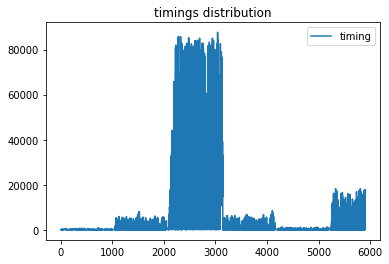

In [1437]:
plot(timestamp_to_timing_X_axis, timestamp_to_timing_Y_axis, "timing", "timings distribution")

In [1438]:
timestamp_to_connections_X_axis = list(map(lambda ts: (ts - time_first).total_seconds(), list(timestamp_to_connections.keys())))
timestamp_to_connections_Y_axis = list(timestamp_to_connections.values())

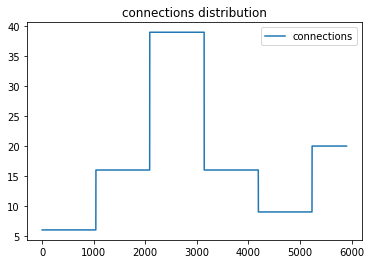

In [1439]:
plot(timestamp_to_connections_X_axis, timestamp_to_connections_Y_axis, "connections", "connections distribution")

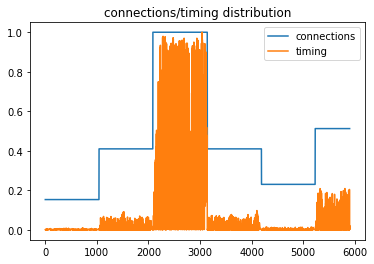

In [1440]:
plot2(timestamp_to_connections_X_axis,
      list(np.array(timestamp_to_connections_Y_axis, dtype=np.float32) / max(timestamp_to_connections_Y_axis)),
      list(np.array(timestamp_to_timing_Y_axis, dtype=np.float32) / max(timestamp_to_timing_Y_axis)),
      "connections",
      "timing",
      "connections/timing distribution")

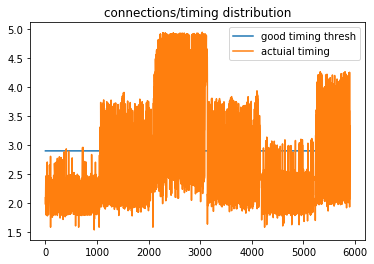

In [1441]:
plot2(timestamp_to_connections_X_axis,
      [np.log10(800.0)] * len(timestamp_to_connections_X_axis),
      list(map(lambda t: np.log10(t), timestamp_to_timing_Y_axis)),
      "good timing thresh",
      "actuial timing",
      "connections/timing distribution")

In [1442]:
df = pd.DataFrame(dataset)

In [1443]:
from sklearn import preprocessing
x = df.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)

In [1444]:
df_scaled_h = df_scaled.drop([0, 1, 2, 16], axis=1)

In [1445]:
df_scaled_h

,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
1,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
2,0.000000,0.984773,0.00000,0.000000,0.000,0.000000,0.256410,0.000000,0.880952,0.0,0.000000,0.0,0.000000
3,0.022270,0.987686,0.01595,0.020941,0.000,0.067918,0.205128,0.000000,0.880952,0.0,0.000000,0.0,0.000000
4,0.022270,0.987686,0.01595,0.020941,0.000,0.067918,0.205128,0.000000,0.880952,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6502,0.986098,0.572189,1.00000,1.000000,0.625,0.045519,0.397436,0.444444,0.920635,0.0,0.134503,0.0,0.005595
6503,0.992413,0.580327,1.00000,1.000000,0.750,0.493315,0.423077,0.444444,0.920635,0.0,0.157895,0.0,0.006375
6504,0.991116,0.592766,1.00000,1.000000,0.750,0.135341,0.384615,0.444444,0.920635,0.0,0.309942,0.0,0.012360
6505,0.991116,0.592766,1.00000,1.000000,0.750,0.135341,0.384615,0.444444,0.920635,0.0,0.473684,0.0,0.018215


In [1446]:
class HardwareVectorModel:
    def __init__(self, df_scaled, train_size):
        self.df_scaled = df_scaled
        self.train_size = train_size
        self.df_scaled_train, self.df_scaled_test = df_scaled[:train_size], df_scaled[train_size:]
        self.models = []
        print(f'Total features: {len(self.df_scaled.keys())}')
        
    def fit(self):
        for feature_to_predict_index in range(len(self.df_scaled.keys())):
            print(f'Train model for feature {feature_to_predict_index}!')
            model = RandomForestRegressor(random_state=42)
            shifted_idx = feature_to_predict_index + 3
            X_train, y_train = self.df_scaled_train.drop([shifted_idx], axis=1).to_numpy(), self.df_scaled_train[shifted_idx]
            #print(X_train.shape, y_train.shape)
            y_train = y_train.shift(-1)
            y_train[len(y_train) - 1] = y_train[len(y_train) - 2]
            y_train = y_train.to_numpy()
            model.fit(X_train, y_train)
            self.models.append(model)
    
    def predict(self, X):
        result = []
        for i, model_i in enumerate(self.models):
            prediction = model_i.predict(np.delete(X, [i]).reshape(1, -1))
            result.append(prediction)
        
        return np.array(result)
    
    def predict_batch(self, X):
        result = []
        for i, model_i in enumerate(self.models):
            prediction = model_i.predict(np.delete(X, [i], axis=1))
            result.append(prediction)
        
        return np.vstack(result)
    
    def get_test(self):
        return self.df_scaled_test

In [1447]:
hvm = HardwareVectorModel(df_scaled_h, int(0.8 * len(df_scaled_h)))

Total features: 13


In [1448]:
hvm.fit()

Train model for feature 0!
Train model for feature 1!
Train model for feature 2!
Train model for feature 3!
Train model for feature 4!
Train model for feature 5!
Train model for feature 6!
Train model for feature 7!
Train model for feature 8!
Train model for feature 9!
Train model for feature 10!
Train model for feature 11!
Train model for feature 12!


In [1449]:
X_test = hvm.get_test().to_numpy()

In [1450]:
X_test.shape

(1302, 13)

In [1451]:
predictions = hvm.predict_batch(X_test)

In [1452]:
predictions = predictions.swapaxes(0, 1)

In [1453]:
X_test_with_preds = X_test[1:]
Preds_with_x_test = predictions[:-1]

In [1454]:
def plot_feature(i, names):
    d1 = X_test_with_preds[:, i]
    d2 = Preds_with_x_test[:, i]
    plot2(list(range(len(d1))), d1, d2, "actual", "predicted", names[i])

In [1455]:
keys = list(df.keys())[3:]

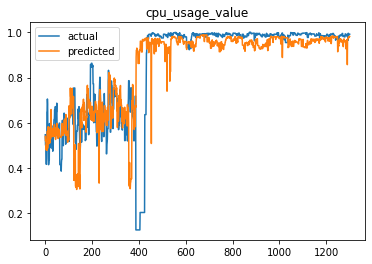

In [1456]:
plot_feature(0, keys)

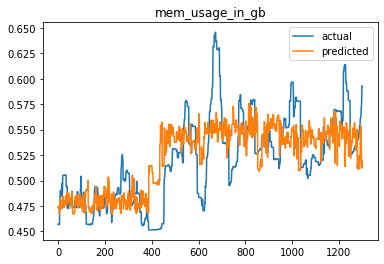

In [1457]:
plot_feature(1, keys)

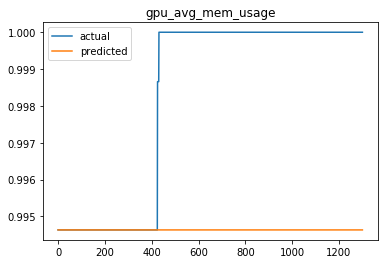

In [1458]:
plot_feature(2, keys)

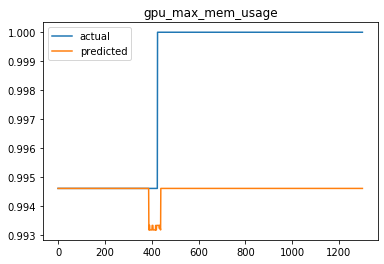

In [1459]:
plot_feature(3, keys)

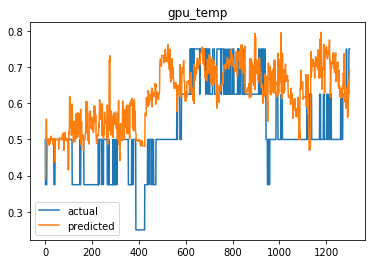

In [1460]:
plot_feature(4, keys)

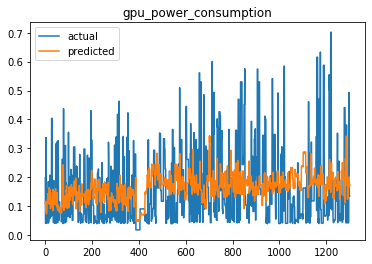

In [1461]:
plot_feature(5, keys)

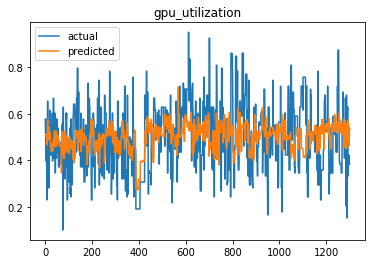

In [1462]:
plot_feature(6, keys)

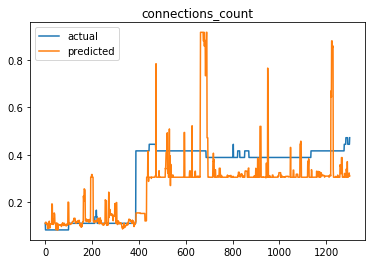

In [1463]:
plot_feature(7, keys)

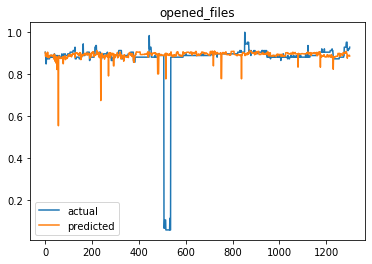

In [1464]:
plot_feature(8, keys)

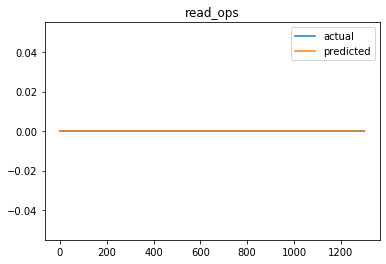

In [1465]:
plot_feature(9, keys)

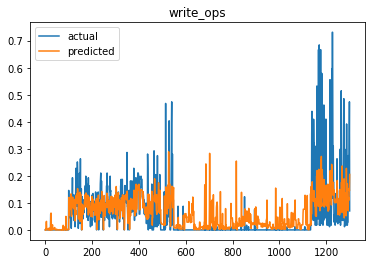

In [1466]:
plot_feature(10, keys)

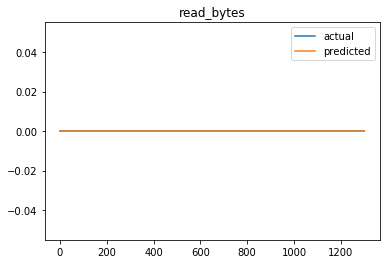

In [1467]:
plot_feature(11, keys)

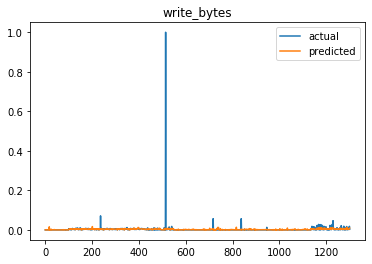

In [1468]:
plot_feature(12, keys)

In [1469]:
dataset_dicts = {}

labels_hardware = []
dataset_hardware = []
keys_hardware = []
for _, h, conn in session_hardware_pairs:
    features_vec = {**h.to_features_dict(), **conn.to_features_dict()}
    ts = max(h.key(), conn.key())
    keys_hardware.append(ts)
    dataset_hardware.append(features_vec)

In [1470]:
dataset_pairs = []

In [1471]:
for k, v in timestamp_to_timing.items():
    i = bisect.bisect_left(keys_hardware, k, lo=0, hi=len(keys_hardware) - 1)
    dataset_pairs.append((dataset_hardware[i], v))

In [1472]:
df_hardware_vectors = pd.DataFrame(list(map(lambda t: {**t[0], **{"label": t[1]}}, dataset_pairs)))

In [1473]:
from sklearn import preprocessing
x = df_hardware_vectors.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_hardware_vectors_scaled = pd.DataFrame(x_scaled)

In [1474]:
df_hardware_vectors_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.984773,0.000000,0.000000,0.000,0.000000,0.256410,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.001027
1,0.022270,0.987686,0.015950,0.020941,0.000,0.067918,0.205128,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000776
2,0.126155,0.993272,0.039659,0.042459,0.000,0.000079,0.333333,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000924
3,0.171059,1.000000,0.060925,0.068972,0.000,0.030523,0.717949,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.000696
4,0.362001,0.000000,0.201504,0.206148,0.125,0.240051,0.461538,0.000000,0.880,0.0,0.000000,0.0,0.000000,0.002556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.001438
6478,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.000593
6479,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.022334
6480,0.991116,0.592766,1.000000,1.000000,0.750,0.135341,0.384615,0.472222,0.928,0.0,0.070175,0.0,0.023346,0.015988


In [1475]:
train_size = int(0.8 * len(df_hardware_vectors_scaled))

In [1476]:
df_hardware_vectors_scaled_train, df_hardware_vectors_scaled_test = df_hardware_vectors_scaled[:train_size], df_hardware_vectors_scaled[train_size:]

In [1477]:
df_hardware_vectors_scaled_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.984773,0.000000,0.000000,0.000,0.000000,0.256410,0.000000,0.880,0.0,0.0,0.0,0.0,0.001027
1,0.022270,0.987686,0.015950,0.020941,0.000,0.067918,0.205128,0.000000,0.880,0.0,0.0,0.0,0.0,0.000776
2,0.126155,0.993272,0.039659,0.042459,0.000,0.000079,0.333333,0.000000,0.880,0.0,0.0,0.0,0.0,0.000924
3,0.171059,1.000000,0.060925,0.068972,0.000,0.030523,0.717949,0.000000,0.880,0.0,0.0,0.0,0.0,0.000696
4,0.362001,0.000000,0.201504,0.206148,0.125,0.240051,0.461538,0.000000,0.880,0.0,0.0,0.0,0.0,0.002556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,0.658279,0.472632,0.994636,0.994621,0.375,0.133644,0.435897,0.083333,0.880,0.0,0.0,0.0,0.0,0.001244
5181,0.617625,0.473241,0.994636,0.994621,0.375,0.040947,0.602564,0.083333,0.880,0.0,0.0,0.0,0.0,0.003150
5182,0.615960,0.472700,0.994636,0.994621,0.500,0.060277,0.576923,0.083333,0.880,0.0,0.0,0.0,0.0,0.003618
5183,0.671621,0.473062,0.994636,0.994621,0.500,0.074863,0.346154,0.083333,0.880,0.0,0.0,0.0,0.0,0.000342


In [1478]:
model_predict_latency = RandomForestRegressor(random_state=42)
X_train, y_train = df_hardware_vectors_scaled_train.drop([13], axis=1).to_numpy(), df_hardware_vectors_scaled_train[13].to_numpy()
print(X_train.shape, y_train.shape)
model_predict_latency.fit(X_train, y_train)

(5185, 13) (5185,)


RandomForestRegressor(random_state=42)

In [1479]:
X_test, y_test = df_hardware_vectors_scaled_test.drop([13], axis=1).to_numpy(), df_hardware_vectors_scaled_test[13].to_numpy()

In [1480]:
X_test.shape

(1297, 13)

In [1481]:
prediction_latency = model_predict_latency.predict(X_test)

In [1482]:
thresh = (600 - min(timestamp_to_timing_Y_axis)) / max(timestamp_to_timing_Y_axis)

In [1483]:
thresh

0.006445283535437652

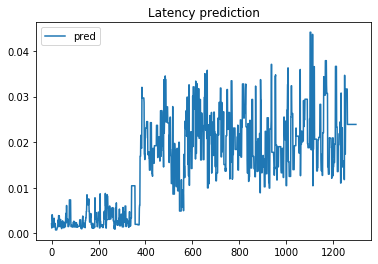

In [1484]:
plot(list(range(len(prediction_latency))), prediction_latency, "pred", "Latency prediction")

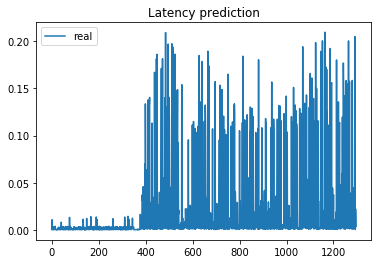

In [1485]:
plot(list(range(len(prediction_latency))), y_test, "real", "Latency prediction")

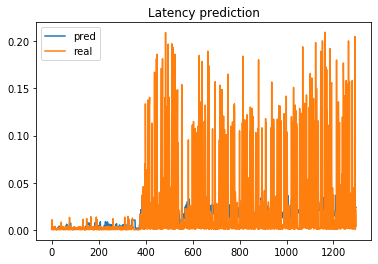

In [1486]:
plot2(list(range(len(prediction_latency))), prediction_latency, y_test, "pred", "real", "Latency prediction")

In [1487]:
def plot_dots(x, y, l, title):
    plt.clf()
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.show()

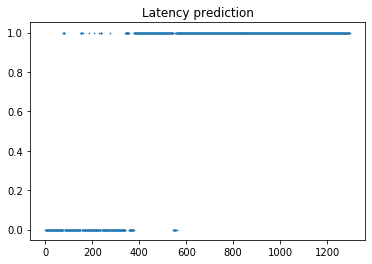

In [1488]:
plot_dots(list(range(len(prediction_latency))), prediction_latency > thresh, "pred", "Latency prediction")

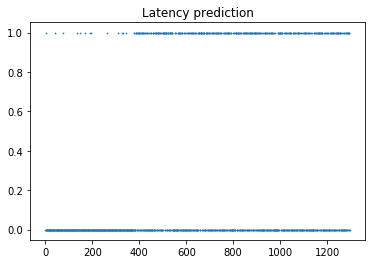

In [1489]:
plot_dots(list(range(len(prediction_latency))), y_test > thresh, "real", "Latency prediction")

In [1490]:
print(f'Total preficted fuckups: {(prediction_latency > thresh).sum()}')
print(f'Total real fuckups: {(y_test > thresh).sum()}')
print(f'Total diff: {np.logical_xor(y_test > thresh, prediction_latency > thresh).sum()}')
print(f'Total false positive: {(((prediction_latency > thresh).astype(int) - (y_test > thresh).astype(int)) == 1).sum()}')
print(f'Total predict zero but real true: {(((y_test > thresh).astype(int) - (prediction_latency > thresh).astype(int)) == 1).sum()}')

Total preficted fuckups: 945
Total real fuckups: 414
Total diff: 557
Total false positive: 544
Total predict zero but real true: 13


In [1491]:
X_test_hvm = hvm.get_test().to_numpy()
predictions = hvm.predict_batch(X_test_hvm)
predictions = predictions.swapaxes(0, 1)

In [1492]:
predictions.shape

(1302, 13)

In [1493]:
a = np.random.rand(3)

In [1494]:
a

array([0.80733891, 0.22847988, 0.36850032])

In [1495]:
b = np.random.rand(3)

In [1496]:
b

array([0.16785028, 0.4456339 , 0.44732147])

In [1497]:
np.hstack([a, b])

array([0.80733891, 0.22847988, 0.36850032, 0.16785028, 0.4456339 ,
       0.44732147])

In [1498]:
np.vstack([a, b])

array([[0.80733891, 0.22847988, 0.36850032],
       [0.16785028, 0.4456339 , 0.44732147]])